In [2]:
from typing import List, Tuple
from dataset.custom_types import ImagesAndCaptions
from argparse import Namespace

from pathlib import Path
from itertools import chain
from tqdm import tqdm

import numpy as np
from sklearn.model_selection import train_test_split
import cv2

from utils import seed_everything
from dataset.vocab import Vocabulary
from dataset.utils import get_captions, combine_image_captions, load_json
from dataset.utils import parse_arguments

In [3]:
# https://pytorch.org/docs/stable/notes/randomness.html


def get_data(json_path: str, imgs_dir: str) -> ImagesAndCaptions:
    """Load annations json file and return a images ids with its captions in
        the following format:
            image_name: {image_id: list of captions tokens}
    """

    annotations, images_id = load_json(json_path)
    captions = get_captions(annotations)
    images_w_captions = combine_image_captions(images_id, captions, imgs_dir)

    return images_w_captions


def split_dataset(
    original_train_split: ImagesAndCaptions,
    original_val_split: ImagesAndCaptions,
    SEED: int,
    test_perc: int = 0.15,
    val_perc: int = 0.15
) -> Tuple[ImagesAndCaptions, ImagesAndCaptions, ImagesAndCaptions]:
    """The size of the original validation split is 4% of the dataset. The
        function calculate the remaining percentage to have a test set of size
        15% of the dataset. Then split the remaining to have a validation
        dataset of 15%.
    """
    train_perc = 1 - (test_perc + val_perc)
    original_val_size = len(original_val_split)
    original_train_size = len(original_train_split)
    ds_size = original_val_size + original_train_size

    # Calculate the remaining size to have 15% of test split (original_val +
    # test_makup)
    test_makup_size = int(ds_size * val_perc) - original_val_size
    train_size = int((train_perc / (1 - test_perc)) *
                     (ds_size - original_val_size - test_makup_size))

    original_train_list = list(original_train_split.items())
    test_makup, train_val = train_test_split(original_train_list,
                                             train_size=test_makup_size,
                                             random_state=SEED,
                                             shuffle=True)

    test_split = {**dict(test_makup), **original_val_split}  # merge two dicts

    train_split, val_split = train_test_split(train_val,
                                              train_size=train_size,
                                              random_state=SEED,
                                              shuffle=True)

    return dict(train_split), dict(val_split), test_split


def buil_vocab(captions: List[chain]) -> Vocabulary:
    all_words = list(chain.from_iterable(captions))
    return Vocabulary(all_words)


In [7]:

SEED = 9001
# seed_everything(seed=SEED)

# parse argument command
# args = parse_arguments()  # type: Namespace

ds_dir = Path("/srv/data/guszarzmo/mlproject/data/mscoco_original/")  
json_train = "caption_annotations/captions_train2017.json"
json_val = "caption_annotations/captions_val2017.json"
image_train = "images/train2017"
image_val = "images/val2017"

train_ann_path = str(ds_dir / json_train)  # train annotations path
val_ann_path = str(ds_dir / json_val)  # val annotations path
train_imgs_dir = str(ds_dir / image_train)  # train images path
val_imgs_dir = str(ds_dir / image_val)  # val images path
# process annotation files
images_captions = get_data(train_ann_path, train_imgs_dir)
images_captions_test = get_data(val_ann_path, val_imgs_dir)

# split dataset
train_ds, val_ds, test_ds = split_dataset(images_captions,
                                            images_captions_test, SEED)

# Create vocab from train dataset set OOV to <UNK>, then encode captions
captions = [chain.from_iterable(d["captions"]) for d in train_ds.values()]
vocab = buil_vocab(captions)

In [41]:
from tqdm.notebook import tqdm

for image_name in tqdm(train_ds, desc="Creating Dataset Images", unit="Image"):
    # image_path = str(ds_dir / image_name)
    img = cv2.imread(image_name)
    b,g,r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): 
        print(image_name)
        break
    # if len(img.shape) == 2:
    #     print(image_name)
    #     # gray-scale
    #     img = img[:, :, np.newaxis]
    #     img = np.concatenate([img, img, img], axis=2)  # [256, 256, 1+1+1]
    #     break

Creating Dataset Images:   0%|          | 0/86300 [00:00<?, ?Image/s]

/srv/data/guszarzmo/mlproject/data/mscoco_original/images/train2017/000000569437.jpg


True


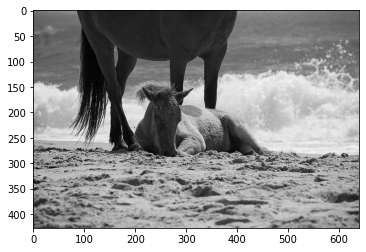

In [40]:
import matplotlib.pyplot as plt
img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(np.all(img == img_))
plt.imshow(img_)
plt.show()

In [32]:
print(image_name)

/srv/data/guszarzmo/mlproject/data/mscoco_original/images/val2017/000000015335.jpg
